# 릿지(alpha=0.1)로 선택한 변수로 돌린 모델_LightGBM(ver6.0) 변수 28개

**[변수 선택 방법]**  
*Ridge( **alpha=0.1** )* + 도출된 회귀계수 크기가 **절댓값 0.3 이상**인 독립변수 선정

**[사용 변수]**  
'생년', '월 평균 총가구소득', '키(센티)', '몸무게(kg)', '지난 2주간 아팠던 날수', '가구 유형', '가장 불편한부위', '장애주된 원인',  
'질병명', '주된 진단명',  '건강보험가입여부 및 형태', '사고발생내용2',  '희귀난치성질환 등록 여부',  '암 종류1', '암 종류2',  
'언어치료-이용여부', '놀이치료-이용여부', '심리행동치료-이용여부',  'ADL-음식물 넘기기', 'ADL-옮겨앉기',  
'ADL-배변', 'ADL-빨래하기', 'ADL-약 챙겨먹기',  '현재 일상생활 도와주는 이유무',  
'주로 도와주는 사람', '팔받침대-사용', '의사소통 보조기기-필요', '이동식 전동리프트-필요'

**[모델링을 위한 파이프라인 구축]**  
Pipeline( [ **(수치형 변수 → StandardScaler / 범주형 변수 → OneHot-Encoding)**, ( **LightGBM()** )] )

**[그리드 서치 후 최적 파라미터 적용 분류 모델링]**   
*LightGBM( **'learning_rate': 0.05, 'max_depth': 5** )*

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgbm
import pickle
import os
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer

In [2]:
df=pd.read_excel("data/지체장애_고혈압_결측치 대체_데이터.xlsx")
df.head()

,id,생년,장애등록 연도,본인을 포함한 총 가구원수,본인을 포함한 총 장애인수,월 평균 총가구소득,가구 월평균 지출액,장애발생시 연령,월 혈압약 일수,관절통증 정도,...,인공호흡기-소지,인공호흡기-사용,사용빈도,1일 이용시간,이용경험-상담과 평가,휴대폰 사용 여부,스마트폰 사용 여부,컴퓨터 사용 여부,인터넷 사용 여부,01)만성질환명(고혈압)
0,1,1970,2008,3,1,280,250,38,0,0,...,2,0,0,0,2,2,1,1,1,0
1,2,1949,2010,3,1,180,150,20,30,0,...,2,0,0,0,2,1,2,2,2,1
2,4,1958,2011,2,1,350,200,51,0,0,...,2,0,0,0,2,2,1,2,2,0
3,5,1955,2009,3,2,154,154,53,30,0,...,2,0,1,3,2,2,1,2,2,1
4,6,1936,2010,2,1,275,270,62,0,7,...,2,0,2,9,1,1,2,2,2,0


In [3]:
df.shape

(2686, 267)

In [3]:
print(df.columns.tolist())

['id', '생년', '장애등록 연도', '본인을 포함한 총 가구원수', '본인을 포함한 총 장애인수', '월 평균 총가구소득', '가구 주된 수입원', '가구 월평균 지출액', '장애발생시 연령_36', '월 혈압약 일수', '관절통증 정도', '운동 시간(분)', '키(센티)', '몸무게(kg)', '성별', '장애등록 여부', '장애등급', '가구 유형', '주택 형태', '장애부위(상지)_31', '장애부위(하지)_32', '장애부위(척추)_33', '가장 불편한부위', '장애발생시기_35', '장애주된 원인', '질병명_38', '산업재해인정여부_39', '주된 진단명_40', '건강보험가입여부 및 형태', '국가유공자, 차상위경감 대상여부', '현재 지속적 진료여부', '주관적 건강 평가', '건강검진 여부', '암검진 여부', '구강건강 검진 여부', '인플루엔자 예방접종여부', '입원치료 여부', '외래진료 여부(치과,보건소,한의원등 포함)', '병의원이나 응급실 이용 사고나중독 발생 여부', '사고발생내용1', '사고발생내용2', '사고발생내용3', '미충족의료 경험 유무', '희귀난치성질환 여부', '희귀난치성질환 등록 여부', '혈압약 복용 여부', '혈당관리 치료 여부', '혈당치료 - 인슐린주사', '혈당치료 - 당뇨병약', '혈당치료 - 비약물요법', '혈당치료 - 기타', '우울증 치료 여부', '암 종류1', '암 종류2', '암 종류3', '지난 2주간 아팠음 여부', '지난 2주간 아팠던 날수', '물리치료-이용여부', '작업치료-이용여부', '언어치료-이용여부', '음악치료-이용여부', '놀이치료-이용여부', '미술치료-이용여부', '심리행동치료-이용여부', '기타-이용여부', '흡연 여부', '최근 1년간 금연시도', '흡연예방교육 여부', '음주횟수', '평균음주량', '건광관리운동', '운동 주기', '재활운동체육 필요여부', '장애인 체육지도자 필요여부', '일정한 시간에 식사여부', '고른 식품 섭취여부', '음식물

In [4]:
df1=df[['생년', '월 평균 총가구소득', '키(센티)', '몸무게(kg)', '지난 2주간 아팠던 날수', '가구 유형', '가장 불편한부위', '장애주된 원인', 
'질병명', '주된 진단명',  '건강보험가입여부 및 형태', '사고발생내용2',  '희귀난치성질환 등록 여부',  '암 종류1', '암 종류2', 
'언어치료-이용여부', '놀이치료-이용여부', '심리행동치료-이용여부',  'ADL-음식물 넘기기', 'ADL-옮겨앉기', 
'ADL-배변', 'ADL-빨래하기', 'ADL-약 챙겨먹기',  '현재 일상생활 도와주는 이유무', 
'주로 도와주는 사람', '팔받침대-사용', '의사소통 보조기기-필요', '이동식 전동리프트-필요', '01)만성질환명(고혈압)']]
df1 #2686건

,생년,월 평균 총가구소득,키(센티),몸무게(kg),지난 2주간 아팠던 날수,가구 유형,가장 불편한부위,장애주된 원인,질병명,주된 진단명,...,ADL-옮겨앉기,ADL-배변,ADL-빨래하기,ADL-약 챙겨먹기,현재 일상생활 도와주는 이유무,주로 도와주는 사람,팔받침대-사용,의사소통 보조기기-필요,이동식 전동리프트-필요,01)만성질환명(고혈압)
0,1970,280,178.0,77.0,14,21,36,64,0,12,...,1,1,1,1,0,0,0,2,2,0
1,1949,180,163.0,55.0,14,21,14,69,0,8,...,1,1,2,1,1,1,0,2,2,1
2,1958,350,158.0,63.0,14,11,38,48,175,11,...,1,1,1,1,0,0,0,2,2,0
3,1955,154,163.0,62.0,14,29,38,48,175,11,...,1,1,1,1,0,0,0,2,2,1
4,1936,275,154.0,57.0,14,24,36,48,171,6,...,3,3,4,2,1,13,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,1935,100,157.0,65.0,14,11,36,68,0,12,...,1,1,2,1,1,1,0,2,2,0
2682,1952,100,165.0,62.0,0,11,38,69,0,12,...,1,1,1,1,0,0,0,2,2,0
2683,1960,223,173.0,88.0,14,11,38,48,175,11,...,1,1,1,1,0,0,0,2,2,1
2684,1960,205,153.0,51.0,14,11,31,48,175,11,...,1,1,1,1,0,0,0,2,2,0


### 결측치가 없는 관측치 하나 미리 빼놓기 (테스트용)

In [5]:
df1[df1['01)만성질환명(고혈압)']==1]

,생년,월 평균 총가구소득,키(센티),몸무게(kg),지난 2주간 아팠던 날수,가구 유형,가장 불편한부위,장애주된 원인,질병명,주된 진단명,...,ADL-옮겨앉기,ADL-배변,ADL-빨래하기,ADL-약 챙겨먹기,현재 일상생활 도와주는 이유무,주로 도와주는 사람,팔받침대-사용,의사소통 보조기기-필요,이동식 전동리프트-필요,01)만성질환명(고혈압)
1,1949,180,163.0,55.0,14,21,14,69,0,8,...,1,1,2,1,1,1,0,2,2,1
3,1955,154,163.0,62.0,14,29,38,48,175,11,...,1,1,1,1,0,0,0,2,2,1
5,1938,160,155.0,60.0,14,11,38,63,0,12,...,1,1,2,1,1,14,0,2,2,1
6,1943,600,145.0,45.0,14,32,14,69,0,8,...,1,1,2,1,1,3,0,2,2,1
7,1945,270,155.0,70.0,14,11,36,48,171,6,...,1,1,2,1,2,0,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,1951,225,167.0,59.0,14,11,36,48,171,6,...,1,1,1,1,0,0,0,2,2,1
2679,1938,93,160.0,39.0,14,11,38,69,0,12,...,1,1,2,1,1,12,0,2,2,1
2680,1951,93,145.0,55.0,14,11,45,61,0,6,...,1,1,2,1,1,12,0,2,2,1
2683,1960,223,173.0,88.0,14,11,38,48,175,11,...,1,1,1,1,0,0,0,2,2,1


In [48]:
out=df1.loc[[2600]] # 유: 3, 32, 2600 / 무: 46, 50, 700  
out

,생년,월 평균 총가구소득,키(센티),몸무게(kg),지난 2주간 아팠던 날수,가구 유형,가장 불편한부위,장애주된 원인,질병명,주된 진단명,...,ADL-옮겨앉기,ADL-배변,ADL-빨래하기,ADL-약 챙겨먹기,현재 일상생활 도와주는 이유무,주로 도와주는 사람,팔받침대-사용,의사소통 보조기기-필요,이동식 전동리프트-필요,01)만성질환명(고혈압)
2600,1942,120,152.0,65.0,14,11,36,48,171,6,...,1,1,1,1,0,0,0,2,2,1


In [49]:
df2=df1.drop(out.index).reset_index(drop=True)
df2.head()

,생년,월 평균 총가구소득,키(센티),몸무게(kg),지난 2주간 아팠던 날수,가구 유형,가장 불편한부위,장애주된 원인,질병명,주된 진단명,...,ADL-옮겨앉기,ADL-배변,ADL-빨래하기,ADL-약 챙겨먹기,현재 일상생활 도와주는 이유무,주로 도와주는 사람,팔받침대-사용,의사소통 보조기기-필요,이동식 전동리프트-필요,01)만성질환명(고혈압)
0,1970,280,178.0,77.0,14,21,36,64,0,12,...,1,1,1,1,0,0,0,2,2,0
1,1949,180,163.0,55.0,14,21,14,69,0,8,...,1,1,2,1,1,1,0,2,2,1
2,1958,350,158.0,63.0,14,11,38,48,175,11,...,1,1,1,1,0,0,0,2,2,0
3,1955,154,163.0,62.0,14,29,38,48,175,11,...,1,1,1,1,0,0,0,2,2,1
4,1936,275,154.0,57.0,14,24,36,48,171,6,...,3,3,4,2,1,13,0,2,2,0


In [50]:
y_data=df2[['01)만성질환명(고혈압)']]

In [51]:
x_data=df2.drop(['01)만성질환명(고혈압)'],axis=1)
x_data

,생년,월 평균 총가구소득,키(센티),몸무게(kg),지난 2주간 아팠던 날수,가구 유형,가장 불편한부위,장애주된 원인,질병명,주된 진단명,...,ADL-음식물 넘기기,ADL-옮겨앉기,ADL-배변,ADL-빨래하기,ADL-약 챙겨먹기,현재 일상생활 도와주는 이유무,주로 도와주는 사람,팔받침대-사용,의사소통 보조기기-필요,이동식 전동리프트-필요
0,1970,280,178.0,77.0,14,21,36,64,0,12,...,1,1,1,1,1,0,0,0,2,2
1,1949,180,163.0,55.0,14,21,14,69,0,8,...,1,1,1,2,1,1,1,0,2,2
2,1958,350,158.0,63.0,14,11,38,48,175,11,...,1,1,1,1,1,0,0,0,2,2
3,1955,154,163.0,62.0,14,29,38,48,175,11,...,1,1,1,1,1,0,0,0,2,2
4,1936,275,154.0,57.0,14,24,36,48,171,6,...,1,3,3,4,2,1,13,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,1935,100,157.0,65.0,14,11,36,68,0,12,...,1,1,1,2,1,1,1,0,2,2
2681,1952,100,165.0,62.0,0,11,38,69,0,12,...,1,1,1,1,1,0,0,0,2,2
2682,1960,223,173.0,88.0,14,11,38,48,175,11,...,1,1,1,1,1,0,0,0,2,2
2683,1960,205,153.0,51.0,14,11,31,48,175,11,...,1,1,1,1,1,0,0,0,2,2


In [52]:
y_data.value_counts()

01)만성질환명(고혈압)
1                1527
0                1158
dtype: int64

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=777)

In [54]:
x_train.columns

Index(['생년', '월 평균 총가구소득', '키(센티)', '몸무게(kg)', '지난 2주간 아팠던 날수', '가구 유형',
       '가장 불편한부위', '장애주된 원인', '질병명', '주된 진단명', '건강보험가입여부 및 형태', '사고발생내용2',
       '희귀난치성질환 등록 여부', '암 종류1', '암 종류2', '언어치료-이용여부', '놀이치료-이용여부',
       '심리행동치료-이용여부', 'ADL-음식물 넘기기', 'ADL-옮겨앉기', 'ADL-배변', 'ADL-빨래하기',
       'ADL-약 챙겨먹기', '현재 일상생활 도와주는 이유무', '주로 도와주는 사람', '팔받침대-사용',
       '의사소통 보조기기-필요', '이동식 전동리프트-필요'],
      dtype='object')

In [55]:
# 그리드 서치 전 모델 생성
lgb_model_pre= lgbm.LGBMClassifier()

# 모델 학습
lgb_model_pre.fit(x_train, y_train)

#모델 검증
print('학습 데이터 점수 :{:.4f}'.format(lgb_model_pre.score(x_train, y_train)))
print('평가 데이터 점수 :{:.4f}'.format(lgb_model_pre.score(x_test, y_test))) 

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


학습 데이터 점수 :0.9399
평가 데이터 점수 :0.6402


In [56]:
numeric_features = x_train.columns.tolist()[:5] 
categorical_features = x_train.columns.tolist()[5:]

column_transformer = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], 
    remainder="passthrough")

In [58]:
# lightgbm 그리드 서치
pipeline = Pipeline([('processor', column_transformer),
                    ('model', lgbm.LGBMClassifier())])

param_grid = {'model__learning_rate': [0.05, 0.1, 0.2],
             'model__max_depth': [3, 5, 7]}

gs = GridSearchCV(estimator = pipeline, param_grid=param_grid, n_jobs=-1, cv = 5)

result = gs.fit(x_train, y_train)

print('최적 파라미터: {}'.format(gs.best_params_)) # 최적의 파라미터 출력
print('최적 점수: {:.4f}'.format(gs.best_score_)) # 최적 파라미터의 평가 점수 출력
print(result.best_estimator_) # 최적 파라미터로 학습된 estimator 출력

최적 파라미터: {'model__learning_rate': 0.05, 'model__max_depth': 3}
최적 점수: 0.6886
Pipeline(steps=[('processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['생년', '월 평균 총가구소득', '키(센티)',
                                                   '몸무게(kg)',
                                                   '지난 2주간 아팠던 날수']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['가구 유형', '가장 불편한부위',
                                                   '장애주된 원인', '질병명', '주된 진단명',
                                                   '건강보험가입여부 및 형태', '사고발생내용2',
                                                   '희귀난치성질환 등록 여부', '암 종류1',
                                                   '암 종류2', '언어치료-이용여부',
                   

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [59]:
#모델 학습
lgbm_model = gs.best_estimator_

In [60]:
x_test=out.drop(['01)만성질환명(고혈압)'],axis=1)
x_test

,생년,월 평균 총가구소득,키(센티),몸무게(kg),지난 2주간 아팠던 날수,가구 유형,가장 불편한부위,장애주된 원인,질병명,주된 진단명,...,ADL-음식물 넘기기,ADL-옮겨앉기,ADL-배변,ADL-빨래하기,ADL-약 챙겨먹기,현재 일상생활 도와주는 이유무,주로 도와주는 사람,팔받침대-사용,의사소통 보조기기-필요,이동식 전동리프트-필요
2600,1942,120,152.0,65.0,14,11,36,48,171,6,...,1,1,1,1,1,0,0,0,2,2


In [61]:
labels = ['무', '유']

In [62]:
# x_test = transformer.transform(x_test)

y_predict = lgbm_model.predict(x_test)
label = labels[y_predict[0]]
y_predict = lgbm_model.predict_proba(x_test)
confidence = round(y_predict[0][y_predict[0].argmax()], 4)

print(label, confidence) 

유 0.8011


---
### 혼동 행렬 작성

테스트 인덱스 번호마다 예측력이 상이하므로 **혼동행렬(=오차행렬, Confusion matrix)로 분류 모델의 성능 파악**하기

In [24]:
x_data = df1.iloc[:,:-1]
y_data = df1.iloc[:,-1]

In [25]:
x_data.head(0)

,생년,월 평균 총가구소득,키(센티),몸무게(kg),지난 2주간 아팠던 날수,가구 유형,가장 불편한부위,장애주된 원인,질병명,주된 진단명,...,ADL-음식물 넘기기,ADL-옮겨앉기,ADL-배변,ADL-빨래하기,ADL-약 챙겨먹기,현재 일상생활 도와주는 이유무,주로 도와주는 사람,팔받침대-사용,의사소통 보조기기-필요,이동식 전동리프트-필요


In [26]:
y_data.head(0)

Series([], Name: 01)만성질환명(고혈압), dtype: int64)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=777)

In [28]:
numeric_features = x_train.columns.tolist()[:5] 
categorical_features = x_train.columns.tolist()[5:]

column_transformer = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], 
    remainder="passthrough")

In [29]:
# lightgbm 그리드 서치
pipeline = Pipeline([('processor', column_transformer),
                    ('model', lgbm.LGBMClassifier())])

param_grid = {'model__learning_rate': [0.05, 0.1, 0.2],
             'model__max_depth': [3, 5, 7]}

gs = GridSearchCV(estimator = pipeline, param_grid=param_grid, n_jobs=-1, cv = 5)

result = gs.fit(x_train, y_train)

print('최적 파라미터: {}'.format(gs.best_params_)) # 최적의 파라미터 출력
print('최적 점수: {:.4f}'.format(gs.best_score_)) # 최적 파라미터의 평가 점수 출력
# print(result.best_estimator_) # 최적 파라미터로 학습된 estimator 출력

최적 파라미터: {'model__learning_rate': 0.05, 'model__max_depth': 5}
최적 점수: 0.6915


In [30]:
# 최적 파라미터 적용한 모델 생성
lgbm_model = gs.best_estimator_

# 예측값 도출
y_pred = lgbm_model.predict(x_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    F1_score = f1_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, F1-score: {:.4f}'.format(accuracy, precision, recall, F1_score))

# 혼동행렬 도출
get_clf_eval(y_test, y_pred)

Confusion Matrix
[[141 209]
 [ 49 407]]
정확도: 0.6799, 정밀도: 0.6607, 재현율: 0.8925, F1-score: 0.7593


[혼동 행렬 참고](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

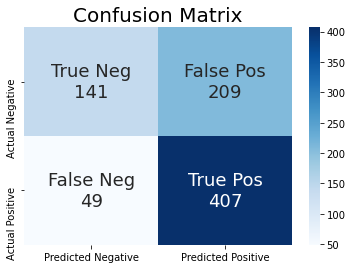

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
confusion = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in confusion.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]

labels = np.asarray(labels).reshape(2,2)

xticklabels = ['Predicted Negative', 'Predicted Positive']
yticklabels = ['Actual Negative', 'Actual Positive']

sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 18},
           xticklabels = xticklabels, yticklabels=yticklabels)
plt.title('Confusion Matrix', fontsize = 20)
# plt.savefig('visual/ver6.0 혼동행렬.png')
plt.show()

TN는 예측값을 Negative로 예측, 실제 값 역시 Negative  
FP는 예측값을 Positive로 예측, 실제 값은 Negative  
FN은 예측값을 Negative로 예측, 실제 값은 Positive  
TP는 예측값을 Positive로 예측, 실제 값 역시 Positive  

---
### 변수 중요도 확인(Feature Importance)
[참고](https://injo.tistory.com/48)

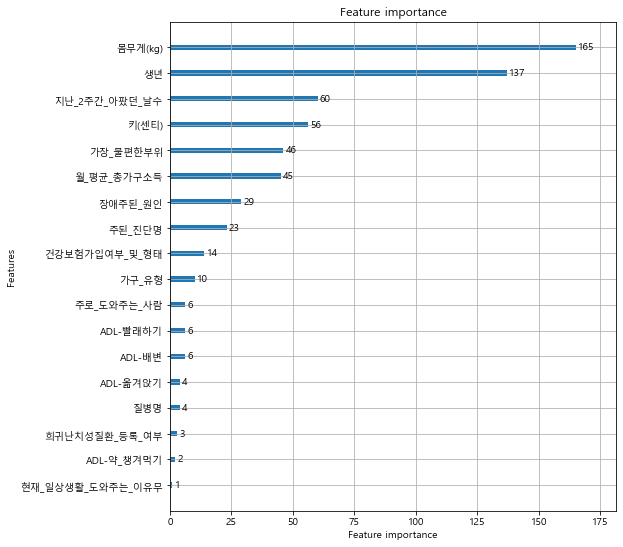

In [32]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')

f, ax = plt.subplots(figsize = (8, 9))

lgbm_model = lgbm.LGBMClassifier(learning_rate=0.05, max_depth=3)
lgbm_model.fit(x_train, y_train)

plot_importance(lgbm_model, ax=ax)
plt.show()